### Notebook for training VAE models with variational SM

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from models.VAEs import AutoEncoder, EBM

import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

%matplotlib inline

dtype = torch.float
torch.set_default_dtype(dtype)

# can change the dataset as wish
# we pad zeros around the MNSIT and FashionMNIST images to make the size 32x32
dataset = datasets.MNIST(root='../data', train=True, transform=torchvision.transforms.Compose([
                                                               torchvision.transforms.Pad(2), 
                                                                transforms.ToTensor(),]), download=True)


test_dataset = datasets.MNIST(root='../data', train=False, transform=torchvision.transforms.Compose([
                                                               torchvision.transforms.Pad(2), 
                                                                transforms.ToTensor(),]), download=True)

# assume there is GPU
device=torch.device("cuda:0")
torch.random.manual_seed(1)

## Choosing the objectives
two types of objectives: 
 * kl: conventional objective for ELBO
 * jf: joint Fisher divergence in Fisher autoencoder

To combine the two inference (KL and FD) and three learning objectives (M1, M2 and M3) in the paper,
specify the inference first ('kl' or 'jf'), followed by '-', and then the learning objective 'xf', 'mf' or 'bmf', respectively
the example below specifies the FD for inference and M1 for learning

In [ ]:
objective = 'jf-xf'

In [14]:
import numpy as np
import torch.nn as nn
import torch.distributions as td
import torch.nn.functional as F

# number of channels
nc = 1
Dz = 100
Dx = 32*32*nc
Dh = 512
lr = 1e-4

# this is N in the paper, number of posterior samples to approximate expectations
M = 5

# layer type: 'conv' for DCGAN, 'resnet' for ResNet18 structure
layer_type = 'conv'
 
# score matching model
model = AutoEncoder(Dz, Dh, Dx, nc = nc, M = M, layer_type=layer_type).to(device=device)
dec_opt = torch.optim.Adam(list(model.decoder.parameters())+[model.logsigma], lr = lr)
enc_opt = torch.optim.Adam(list(model.encoder.parameters()), lr = lr)

enc_losses = []
dec_losses = []
ml_losses = []
sm_losses = []

errors = []

In [ ]:
bs = 100
K = 5
N = 5

data_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=8)

# only train for 50 epochs in the notebook example.
for i in tqdm.tqdm(range(0, 50)):

    sm_noise_std = 0.1

    for idx, (images, _) in enumerate(tqdm.tqdm(data_loader, leave=False)):
        
        learning_step = idx % K == (K-1)
            
        images = torch.as_tensor(images).to(dtype)

        #####  VAE  #####
        clean_x = images.view(bs, -1).to(device)

        if objective in ["kl", "jf"]:

            if objective == "kl":
                loss = model.ELBO(clean_x)
            else:
                loss = model.joint_score(clean_x, reparam=True)

            enc_opt.zero_grad()
            loss.backward(retain_graph=False)
            enc_opt.step()

            if learning_step:
                if objective == "kl":
                    loss = model.ELBO(clean_x)
                else:
                    loss = model.joint_score(clean_x)
                dec_opt.zero_grad()
                loss.backward(retain_graph=False)
                dec_opt.step()

        else:

            i_obj, l_obj = objective.split('-')

            if i_obj == "kl":
                loss_z = model.ELBO(clean_x)
            elif i_obj == "jf":
                loss_z = model.score_z(clean_x)
            else:
                raise NameError('Please specify the correct inference objective')
            enc_opt.zero_grad()
            loss_z.backward()
            enc_opt.step()

            if learning_step:
                if l_obj == "xf":
                    loss_x = model.joint_score_x(clean_x)
                elif l_obj == "mf":
                    loss_x = model.marginal_score(clean_x)
                elif l_obj == "bmf":
                    loss_x = model.bad_marginal_score(clean_x)
                else:
                    raise NameError('Please specify the correct learning objective')

                dec_opt.zero_grad()
                loss_x.backward()
                dec_opt.step()

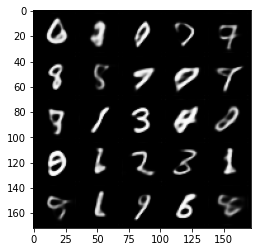

In [21]:
## helper to conver tensor to concatenated images
def tensor_to_image(x):
    x = x[:25]
    x = np.transpose(make_grid(x.reshape(x.shape[0],nc,32,32), nrow=5).cpu().detach().numpy(), [1,2,0])
    return x

z = model.prior.sample([25])
im = tensor_to_image(model.decode(z).mean)
plt.figure()
plt.imshow(im)